# **Rodrigo_Mesquita_PB_TP4**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

**Objetivos:**

* Investigar a eficácia do uso de clusters gerados pelo algoritmo K-Médias como features adicionais em tarefas de classificação.
* Comparar o desempenho de modelos SVM treinados com e sem o uso dessas features derivadas de clusterização em conjuntos de dados variados.
* Avaliar a influência do número de clusters e da seleção de parâmetros no desempenho do modelo SVM final.
* Desenvolver diretrizes para a aplicação efetiva de técnicas de clusterização em engenharia de features para aprendizado supervisionado.

### 1.Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

In [56]:
from sklearn.datasets import load_iris, load_digits, load_breast_cancer, load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline   import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score


### 2.Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

In [60]:
def carregar_df_e_treinar_kmeans(nome_dataset):
    np.random.seed(42)

    #Carregar e splitar o dataset
    df = nome_dataset()
    X = df.data
    Y = df.target

    X_std = StandardScaler().fit_transform(X)

    #Treinar o Kmeans e iterar com diferentes valores de K para avaliar a quantidade idade, utilizando os métodos elbow e silhouette
    elbow, silhouette = {},{}
    for k in range(2, 31, 1):
        model = KMeans(n_clusters= k, max_iter=1000,n_init=1, random_state=42).fit(X_std)
        preds = model.predict(X_std)
        elbow[k] = mean_squared_error(Y,preds)
        silhouette[k] = silhouette_score(X_std,preds)

    #Plortar os gráficos de Elbow e Silhouete
    maximo = max(elbow.values())
    for key in elbow:
        elbow[key] = float(elbow[key]) / maximo

    #Gráfico Elbow
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(list(elbow.keys()), list(elbow.values()), label="Método Elbow", color='b')
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_ylabel('MSE', fontsize=12, color='b')
    ax1.set_ylim(0, 1)
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper right')

    #Ajustar o Xticks para que seja de 1 em 1
    ax1.set_xticks(list(elbow.keys()))
    ax1.set_xticklabels(list(elbow.keys()))
    #Adicionar grid vertical
    ax1.grid(visible=True, axis='x', linestyle='-', color='gray', alpha=0.5)

    
    # Gráfico Silhouete
    ax2 = ax1.twinx()
    ax2.plot(list(silhouette.keys()), list(silhouette.values()), label="Método Silhouette", color='r')
    ax2.set_ylabel('Silhouette Score', fontsize=12, color='r')
    ax2.set_ylim(0, 1)
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper center')

    plt.title('Elbow Plot e Silhouette Plot')
    plt.show()

In [67]:
#Função para criar os novos datasets com adição da Feature de distância

def dist_feature(nome_dataset,k):

    df = nome_dataset()
    X = df.data
    Y = df.target

    model = KMeans(n_clusters= k, max_iter=1000,n_init=1, random_state=42).fit(X)
    preds = model.predict(X)
    cluster_centers = model.cluster_centers_

    distances = []
    for x in X:
        distances.append(np.min([np.linalg.norm(x - center) for center in cluster_centers]))

    X_new = np.column_stack((X, distances))
    return X, Y, X_new


### 3.Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Use:
### E
### 4.Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

### 3a.Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.

In [70]:
#Função para treinar os modelos SVM e calcular as métricas

def treinar_svm(X1,X2,Y):

    #A função recebe 2 conjuntos de testes distintos, o que original e o que possui a feature de distância calculada pelo K-Means
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.3, random_state=20)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.3, random_state=20)

    #Estabeleço os parâmetros de regularização
    param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'],
        'C': [0.001, 0.01, 0.1, 1, 10,100]
    }
    grid1 = GridSearchCV(SVC(), param_grid, cv=5)

    #Treino primeiro o modelo com o df original
    grid1.fit(x_train1, y_train1)
    y_pred1 = grid1.predict(x_test1)

    print('\nResultados com Dataframe Original')
    print(f"Melhores Parâmetros: {grid1.best_params_}", f"\nMelhores Score: {grid1.best_score_:.2f}")
    print(f"Precisão: {precision_score(y_test1, y_pred1, average='macro'):.2f}")
    print(f"Recall (sensibilidade): {recall_score(y_test1, y_pred1, average='macro'):.2f}")
    print(f"F1-score: {f1_score(y_test1, y_pred1, average='macro'):.2f}")


    #Depois treino o modelo com o df que possui feature calculada
    grid2 = GridSearchCV(SVC(), param_grid, cv=5)
    grid2.fit(x_train2, y_train2)
    y_pred2 = grid2.predict(x_test2)

    print('\nResultados com Feature Adicionada')
    print(f"Melhores Parâmetros: {grid2.best_params_}", f"\nMelhores Score: {grid2.best_score_:.2f}")
    print(f"Precisão: {precision_score(y_test2, y_pred2, average='macro'):.2f}")
    print(f"Recall (sensibilidade): {recall_score(y_test2, y_pred2, average='macro'):.2f}")
    print(f"F1-score: {f1_score(y_test2, y_pred2, average='macro'):.2f}")

    return y_test1, y_pred1, y_test2, y_pred2

In [133]:
#Criada função para imprimir as matrizes de confusão:
def matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W,H):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(W, H))

    cm1 = metrics.confusion_matrix(y_test1, y_pred1)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
    disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
    ax1.set_title('DF Original')

    cm2 = metrics.confusion_matrix(y_test2, y_pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
    ax2.set_title('Feature Adicionada')

    plt.tight_layout()
    plt.show()
    
'''
    vp1 = np.diag(cm1).sum()
    fp1 = cm1.sum(axis=0) - vp1
    fn1 = cm1.sum(axis=1) - vp1
    tn1 = cm1.sum() - vp1 - fp1 - fn1

    specificity = tn1 / (tn1 + fp1)
    print(vp1)
    print(fp1)
    print(fn1)
    print(tn1)
    print(specificity)
    print(f"Especificidade: {specificity[0]:.2f}")
'''



'\n    vp1 = np.diag(cm1).sum()\n    fp1 = cm1.sum(axis=0) - vp1\n    fn1 = cm1.sum(axis=1) - vp1\n    tn1 = cm1.sum() - vp1 - fp1 - fn1\n\n    specificity = tn1 / (tn1 + fp1)\n    print(vp1)\n    print(fp1)\n    print(fn1)\n    print(tn1)\n    print(specificity)\n    print(f"Especificidade: {specificity[0]:.2f}")\n'

### **IRIS (Melhor K = 3)**

RESULTADO DATASET IRIS


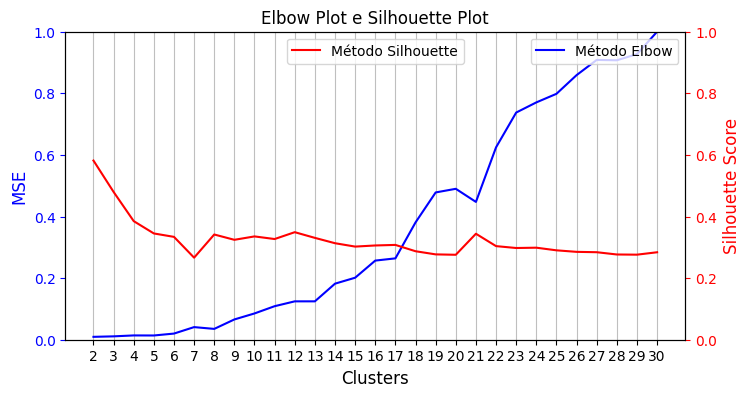

In [63]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET IRIS')
carregar_df_e_treinar_kmeans(load_iris)

In [ ]:
#Treinando modelo novamente com o melhor K
x_iris,y_iris, x_iris_new = dist_feature(load_iris, k=3)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_iris, x_iris_new, y_iris)

In [ ]:
#Apresentando matriz de confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

In [ ]:
### Achei que os resultados estavam indicando Over-fit, então plotei treinei novamente com os melhores parâmetros mas iterando o valor de C para analisar as curvas de treino e teste.

x_train, x_test, y_train, y_test = train_test_split(x_iris, y_iris, test_size=0.3, random_state=20)

C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
acc_train, acc_test = [],[]

for i in C:
    model = SVC(C=i, kernel='linear')
    model.fit(x_train, y_train)

    #Avaliar score com dados de treino
    train_pred = model.predict(x_train)
    acc_train.append(accuracy_score(y_train, train_pred))

    #Avaliar score com dados de teste
    test_pred = model.predict(x_test)
    acc_test.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(4,2))
plt.title('Acurácia')
plt.semilogx(C, acc_train, '-o', label='ACC treino')
plt.semilogx(C, acc_test, '-o', label='ACC teste')
plt.legend()

### **DIGITS (Melhor K = 7)**

RESULTADO DATASET DIGITS


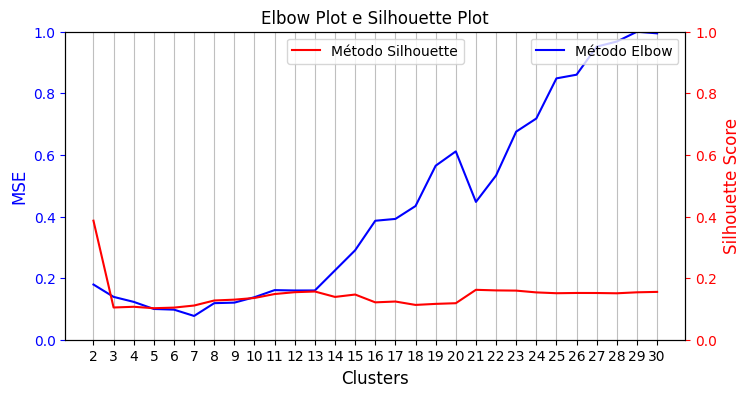

In [62]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET DIGITS')
carregar_df_e_treinar_kmeans(load_digits)

In [ ]:
#Treinando modelo novamente com o melhor K
x_dig,y_dig, x_dig_new = dist_feature(load_digits, k=13)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_dig, x_dig_new, y_dig)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=6,H=6)

### **WINE (Melhor K = 3)**

RESULTADO DATASET WINE


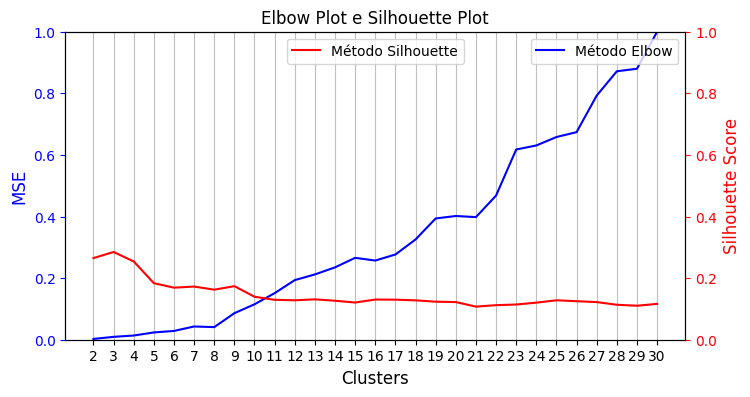

In [64]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET WINE')
carregar_df_e_treinar_kmeans(load_wine)

In [ ]:
#Treinando modelo novamente com o melhor K
x_wine,y_wine, x_wine_new = dist_feature(load_wine, k=3)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_wine, x_wine_new, y_wine)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

### **BREAST CANCER (Melhor K = 2)**

RESULTADO DATASET BREAST CANCER


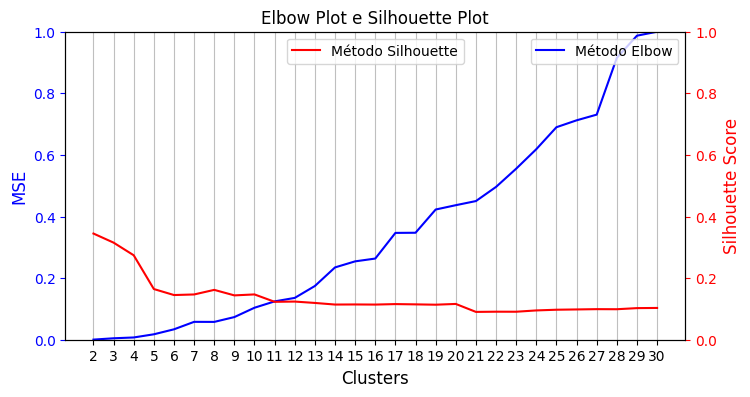

In [65]:
#Descoberta do Melhor K para criação da Feature baseada na distância dos Clusters
print('RESULTADO DATASET BREAST CANCER')
carregar_df_e_treinar_kmeans(load_breast_cancer)

In [ ]:
#Treinando modelo novamente com o melhor K
x_cancer,y_cancer, x_cancer_new = dist_feature(load_breast_cancer, k=2)

In [ ]:
#Apresentando os resultados
y_test1, y_pred1, y_test2, y_pred2 = treinar_svm(x_cancer, x_cancer_new, y_cancer)

In [ ]:
#Apresentando Matriz de Confusão
matrizes_paralelas(y_test1,y_test2,y_pred1,y_pred2,W=4,H=4)

### **IRIS**

In [131]:
mc = metrics.multilabel_confusion_matrix(y_test1, y_pred1)
TP = mc[:, 1, 1]
FN = mc[:, 1, 0]
FP = mc[:, 0, 1]
TN = mc[:, 0, 0]

print("TP:", TP)
print("FN:", FN)
print("FP:", FP)
print("TN:", TN)

TP: [13 18 11]
FN: [0 0 3]
FP: [0 3 0]
TN: [32 24 31]



### 3b.Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

## 5.Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho. Use gráficos para ilustrar seus argumentos.